# Sortify

The goal is to automatically pre-sort the playlists I regularly create for the Rock 4 Temps club parties I'm part of.

Main objectives:
* Play first the most known musics
* Alternate slow and fast music

Secondary objectives:
* Display a histogram of bpm, ideally the majority should be close to 120 (for this type of dance)
* Display the "Title - Artist" list to easily generate the PDF for the evening.

## Get tracks

In [163]:
import os

import spotipy
from spotipy.oauth2 import SpotifyOAuth

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [164]:
c_id = os.environ['c_id']
c_secret = os.environ['c_secret']

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=c_id,
                                               client_secret=c_secret,
                                               redirect_uri="https://127.0.0.1",
                                               scope="""
                                               playlist-read-private playlist-modify-private playlist-modify-public 
                                               playlist-read-collaborative user-library-modify"""))

In [165]:
results = sp.current_user_playlists(limit=50)

In [ ]:
for playlist in results['items']:
    print(playlist['name'], playlist['id'])

In [167]:
playlist_id = "4FNN7270AruT0qJqpOq4dw"

In [168]:
playlist_tracks = sp.user_playlist_tracks(playlist_id=playlist_id)

In [169]:
print(playlist_tracks['items'][0].keys())
print(playlist_tracks['items'][0]['track'].keys())
print(playlist_tracks['items'][0]['track']['album'].keys())

dict_keys(['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail'])
dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'episode', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track', 'track_number', 'type', 'uri'])
dict_keys(['album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])


In [170]:
tracks = []
for track in playlist_tracks['items']:
    t = track['track']
    features = sp.audio_analysis(t['id'])
    track = {
        'id': t['id'],
        'artist': ', '.join([artist['name'] for artist in t['artists']]),
        'name': t['name'],
        'duration_ms': t['duration_ms'],
        'explicit': t['explicit'],
        'release_date': t['album']['release_date'],
        'popularity': t['popularity'],
    }
    
    tracks.append(track)

df = pd.DataFrame(tracks)
df

,id,artist,name,duration_ms,explicit,release_date,popularity
0,0e8nrvls4Qqv5Rfa2UhqmO,Lil Nas X,THATS WHAT I WANT,143901,True,2021-09-17,93
1,0Uon5NsSAkBDx69XYOaQ5P,Gracie Abrams,Stay,177152,False,2019-11-21,71
2,1rqqCSm0Qe4I9rUvWncaom,Panic! At The Disco,High Hopes,190946,False,2018-06-22,83
3,3n2P3ipLt5mPFVaM0fJHNR,"CHROMANCE, Marcus Layton",Wrap Me In Plastic - Marcus Layton Radio Edit,193320,False,2019-11-15,68
4,4n7jnSxVLd8QioibtTDBDq,"Alan Walker, Sabrina Carpenter, Farruko",On My Way,193797,True,2019-03-21,77
5,4U7G8dgUodMEVSv96QRcDb,"Cadmium, Rosendale",No Friends,235023,False,2020-03-06,68
6,7weX6syqklVQocpVVmDNwI,Why Don't We,Love Back,185850,False,2021-10-06,73
7,5iDaEbPX8Lq2evx3ZpAgQU,june,A Little Messed Up,168000,False,2019-11-15,62
8,64UmuvjJk7CxLZB6pKTrsS,"Silva Hound, Michael Kovach, Chi-Chi",Addict,245624,True,2020-02-14,62
9,5XGjHvW9kqp8QqFpMHmESt,Royal & the Serpent,Weddings & Funerals,176597,False,2019-04-26,54


## Get audio features

In [171]:
features = pd.DataFrame(sp.audio_features(tracks=df['id']))
for col in ['energy', 'mode', 'tempo']:
    df[col] = features[col]
df

,id,artist,name,duration_ms,explicit,release_date,popularity,energy,mode,tempo
0,0e8nrvls4Qqv5Rfa2UhqmO,Lil Nas X,THATS WHAT I WANT,143901,True,2021-09-17,93,0.846,0,87.981
1,0Uon5NsSAkBDx69XYOaQ5P,Gracie Abrams,Stay,177152,False,2019-11-21,71,0.370,1,114.260
2,1rqqCSm0Qe4I9rUvWncaom,Panic! At The Disco,High Hopes,190946,False,2018-06-22,83,0.904,1,82.014
3,3n2P3ipLt5mPFVaM0fJHNR,"CHROMANCE, Marcus Layton",Wrap Me In Plastic - Marcus Layton Radio Edit,193320,False,2019-11-15,68,0.612,0,89.961
4,4n7jnSxVLd8QioibtTDBDq,"Alan Walker, Sabrina Carpenter, Farruko",On My Way,193797,True,2019-03-21,77,0.689,0,170.087
5,4U7G8dgUodMEVSv96QRcDb,"Cadmium, Rosendale",No Friends,235023,False,2020-03-06,68,0.644,1,145.029
6,7weX6syqklVQocpVVmDNwI,Why Don't We,Love Back,185850,False,2021-10-06,73,0.744,1,105.882
7,5iDaEbPX8Lq2evx3ZpAgQU,june,A Little Messed Up,168000,False,2019-11-15,62,0.528,0,96.060
8,64UmuvjJk7CxLZB6pKTrsS,"Silva Hound, Michael Kovach, Chi-Chi",Addict,245624,True,2020-02-14,62,0.786,0,127.941
9,5XGjHvW9kqp8QqFpMHmESt,Royal & the Serpent,Weddings & Funerals,176597,False,2019-04-26,54,0.581,0,96.640


## Sort / Reindex

In [172]:
median_energy = np.median(df['energy'])

df = df.sort_values('popularity', ascending=False).reset_index(drop=True)

df_inf_median = df[df["energy"] < median_energy]
df_sup_median = df[df["energy"] >= median_energy]

print(df_inf_median.shape)
print(df_sup_median.shape)

(8, 10)
(8, 10)


In [173]:
ids_ordered = []
for id1, id2 in zip(df_sup_median['id'].values, df_inf_median['id'].values):
    ids_ordered.append(id1)
    ids_ordered.append(id2)
print(ids_ordered)

['0e8nrvls4Qqv5Rfa2UhqmO', '0Uon5NsSAkBDx69XYOaQ5P', '1rqqCSm0Qe4I9rUvWncaom', '3n2P3ipLt5mPFVaM0fJHNR', '4n7jnSxVLd8QioibtTDBDq', '4U7G8dgUodMEVSv96QRcDb', '7weX6syqklVQocpVVmDNwI', '5iDaEbPX8Lq2evx3ZpAgQU', '64UmuvjJk7CxLZB6pKTrsS', '5XGjHvW9kqp8QqFpMHmESt', '3zJeRYExRbqUbuynS6X8ZO', '4O5BcYOGpbutyUhwExTSYu', '5EhXpH8kkPEay1UyjBPgzb', '3B3LaCPJ0PJZzXhGh1Nkzv', '4F1wRJpj3i83yf7FBTo1W7', '3s8Zq2jGW1rIDKYme02J85']


## Replace in Playlist

In [174]:
sp.playlist_replace_items(playlist_id, ids_ordered)

{'snapshot_id': 'MjEsOTU1OWQ4YWIwM2MxY2RjNmVjOWE2NTZlMGVlNzRjM2Q2NTI0OTYyYg=='}

## Generate PDF

In [175]:
playlist_tracks = sp.user_playlist_tracks(playlist_id=playlist_id)

for track in playlist_tracks['items']:
    t = track['track']
    print(t['name'], "-", ', '.join([artist['name'] for artist in t['artists']]))

THATS WHAT I WANT - Lil Nas X
Stay - Gracie Abrams
High Hopes - Panic! At The Disco
Wrap Me In Plastic - Marcus Layton Radio Edit - CHROMANCE, Marcus Layton
On My Way - Alan Walker, Sabrina Carpenter, Farruko
No Friends - Cadmium, Rosendale
Love Back - Why Don't We
A Little Messed Up - june
Addict - Silva Hound, Michael Kovach, Chi-Chi
Weddings & Funerals - Royal & the Serpent
B.O.M.B. - emlyn
Strange - Silent Child, margø
Oh My God - Gia Woods
love is scary (feat. Emilia Ali) - dwilly, Emilia Ali
Burn - Marnik, ROOKIES
Villain - Fokushi


# Statistics

<AxesSubplot:>

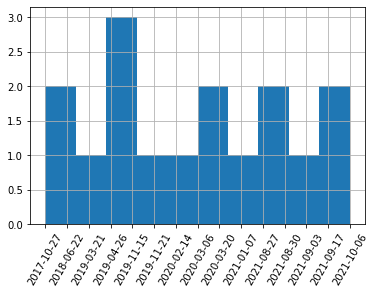

In [176]:
df.sort_values('release_date')['release_date'].hist(xrot=60)

count     16.000000
mean     114.837187
std       28.810780
min       80.018000
25%       94.263750
50%      105.441500
75%      136.018500
max      170.087000
Name: tempo, dtype: float64


<AxesSubplot:>

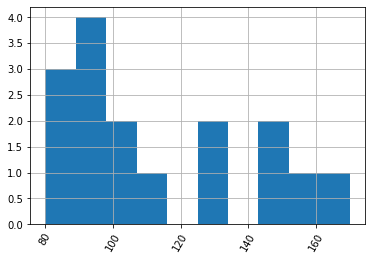

In [177]:
print(df.sort_values('tempo')['tempo'].describe())
df.sort_values('tempo')['tempo'].hist(xrot=60)